# Toxic Comments-Detection (PyTorch)

## Data preparation & preprocessing

### Import libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *

### Load the pretrained word embeddings & dataset

We load the pretrained GloVe (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.) as the word embeddings and perform transfer learning.

In [2]:
EMBEDDING_DIM = 50

print('Loading word embeddings...')
word2vec = {}
with open(os.path.join('./glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as file:
    for line in file:
        values = line.split()
        word = values[0]
        embedding_vector = np.asarray(values[1:], dtype='float32')
        word2vec[word] = embedding_vector
print('A total of %s word embeddings were founded.' % len(word2vec))

Loading word embeddings...
A total of 400000 word embeddings were founded.


Load the training data

In [3]:
print('Loading training data...')
train_raw = pd.read_csv("./data/train.csv")
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train_raw[label_names].values
print('Data loaded!')

Loading training data...
Data loaded!


Have a look at the raw data

In [4]:
target = (
    train_raw['toxic']
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'index':'Target', 'toxic':'Count'})
    .replace([0,1], ['Normal', 'Toxic'])    
          ) 

print(target)

   Target   Count
0  Normal  144277
1   Toxic   15294


### Cleanse the data

Cleanse the data, which is done by the class 'TextDataPreprocessor' written in 'preprocessing.py'. Inspect how many words in the vocabulary as well as in all the texts have available embeddings before and after the cleansing process. We can see that there's a huge increase of the percentage of words that find corresponding embeddings.  

In [5]:
MAX_NUM_WORDS = 20000
MIN_SEQ_LENGTH = 100

print('-'*21 + '\n|Before cleansing...|\n' + '-'*21)
vocab = corpus_to_vocab(train_raw['comment_text'])
oov_words = embedding_coverage(vocab, word2vec)
print(f"oov word examples:\n{oov_words[:10]}")

print('-'*21 + '\n|Cleansing corpus...|\n' + '-'*21)
train = pd.DataFrame()
preprocessor = TextDataPreprocessor(max_num_words = MAX_NUM_WORDS, min_seq_length = MIN_SEQ_LENGTH)
train['comment_text'] = preprocessor.cleanse_corpus(train_raw['comment_text'])

print('-'*20 + '\n|After cleansing...|\n' + '-'*20)
vocab = corpus_to_vocab(train['comment_text'])
oov_words = embedding_coverage(vocab, word2vec) 
print(f"oov word examples:\n{oov_words[:10]}")


---------------------
|Before cleansing...|
---------------------
Embeddings founded for 10.82% of vocab
Embeddings founded for 71.92% of all texts
oov word examples:
[('I', 183930), ('The', 39578), ('If', 25463), ('You', 22107), ("don't", 20298), ('Wikipedia', 17585), ("I'm", 16519), ('It', 16414), ('Please', 15994), ('This', 15772)]
---------------------
|Cleansing corpus...|
---------------------
--------------------
|After cleansing...|
--------------------
Embeddings founded for 45.86% of vocab
Embeddings founded for 97.52% of all texts
oov word examples:
[('•', 5299), ("wikipedia's", 2706), ('contribs', 2634), ('npov', 1867), ('wikiproject', 1842), ("article's", 1614), ('tildes', 1436), ('wikipedian', 1270), ('barnstar', 1032), ("''''''", 1021)]


### Tokenization and build data structures required by further NLP tasks

Fit the preprocessor on the cleansed corpus.

In [6]:
preprocessor.fit_on_corpus(train['comment_text'])
embedding_matrix = preprocessor.build_embedding_matrix(EMBEDDING_DIM, word2vec)

Inspect the outputs.

In [7]:
print(f"The most frequent words:\n{preprocessor.sorted_vocab[:10]}")
print("~"*100)
print("The word-to-index map:")
for word, idx in list(preprocessor.word2idx.items())[:10]:
    print(f"{word}: {idx}")
print("~"*100)
print("The shape of the embedding matrix:")
print(embedding_matrix.shape)

The most frequent words:
[('the', 496580), ('to', 299016), ('i', 242096), ('of', 225313), ('and', 224198), ('you', 223841), ('a', 215746), ('is', 215682), ('that', 161662), ('not', 151265)]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The word-to-index map:
the: 1
to: 2
i: 3
of: 4
and: 5
you: 6
a: 7
is: 8
that: 9
not: 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The shape of the embedding matrix:
(20000, 50)


Check out some properties of the sequences

In [8]:
print('Before padding:')
print('Max sequence length: %i' % max(len(s) for s in preprocessor.sequences))
print('Min sequence length: %i' % min(len(s) for s in preprocessor.sequences))
seq_length = [len(s) for s in preprocessor.sequences]
print('Median sequence length: %i' %np.median(seq_length))

print('~'*100)

print('After padding:')
print('Max sequence length: %i' % max(len(s) for s in preprocessor.padded_sequences))
print('Min sequence length: %i' % min(len(s) for s in preprocessor.padded_sequences))
seq_length = [len(s) for s in preprocessor.padded_sequences]
print('Median sequence length: %i' %np.median(seq_length))

Before padding:
Max sequence length: 1400
Min sequence length: 0
Median sequence length: 35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
After padding:
Max sequence length: 100
Min sequence length: 100
Median sequence length: 100


Check out how many unique tokens we found in the corpus

In [9]:
# Word -> integer mapping
word2idx = preprocessor.word2idx
print('Found %i unique tokens' %len(word2idx))

Found 208509 unique tokens


## Build the model

Here we build a model composed of a bidirectional GRU with the attention mechanism to rate the toxicities of the comments.

### Import libraries

In [10]:
import torch
import torch.nn as nn

### Write related classes

In [11]:
class Model(nn.Module):
    def __init__(self, num_words, embedding_dim, embedding_matrix, hidden_dim, units, output_dim, drp2D_rate = 0.1, drp_rate = 0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        self.embedding_layer = nn.Embedding(num_words, embedding_dim)
        self.embedding_layer.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding_layer.weight.requires_grad = False
        
        self.dropout2d = nn.Dropout2d(drp2D_rate)
        self.bi_gru = nn.GRU(embedding_dim, hidden_dim, bidirectional = True, batch_first = True)
        self.attention_layer = AttentionLayer(2 * hidden_dim, units)
        self.linear_1 = nn.Linear(2 * hidden_dim, 64)
        self.dropout = nn.Dropout(drp_rate)
        self.linear_2 = nn.Linear(64, 6)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, seqs):
        x = self.embedding_layer(seqs)
        x = self.dropout2d(x)
        values, query = self.bi_gru(x)
        query = query.transpose(0, 1)
        query = query.reshape(-1, self.hidden_dim * 2)
        x, _ = self.attention_layer(values, query)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        outputs = self.sigmoid(self.linear_2(x))

        return outputs


class AttentionLayer(nn.Module):
    """
            Attention scores: e = tanh(W1*values + W2*query)
            Attention weights: alpha = softmax(e)
            Attention output/context vector: a = sum(alpha*values)
    """
    def __init__(self, concat_hidden_dim, units):
        super().__init__()
        self.concat_hidden_dim = concat_hidden_dim
        self.W_values = nn.Linear(concat_hidden_dim, units)
        self.W_query = nn.Linear(concat_hidden_dim, units)
        self.V = nn.Linear(units, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, values, query):
        """
                values: (batch_size, seq_len, concat_hidden_dim)
                query: (batch_size, concat_hidden_dim) -> (batch_size, 1, concat_hidden_dim)
                scores: (batch_size, seq_len, 1)
                attention_weights: (batch_size, seq_len, 1)
                context_vector: (batch_size, concat_hidden_dim)
        """
        query_expanded = query.unsqueeze(dim = 1)
        scores = self.V(self.tanh(self.W_values(values) + self.W_query(query_expanded)))  # Broadcasting
        attention_weights = self.softmax(scores)
        context_vector = attention_weights * values  # Broadcasting
        context_vector = torch.sum(context_vector, dim = 1)

        return context_vector, attention_weights

In [12]:
model = Model(preprocessor.num_words, EMBEDDING_DIM, embedding_matrix, 64, 10, 6)

In [13]:
# print(torch.tensor(preprocessor.padded_sequences[:5]))
# print(model(torch.tensor(preprocessor.padded_sequences[:5])))

## Train the model

### Write the training loop

In [26]:
################# BUILDING MODEL ###################
import time

def experiment(train_dataset, val_dataset, args):
    model = Model(preprocessor.num_words, EMBEDDING_DIM, embedding_matrix, 64, 10, 6)

    print(model)
    
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = args.batch_size, shuffle = False)

    if args.gpu:
        # ****** Copy model to device ****** #
        model.to(device)

    # ====== Loss function ====== #
    lossfunction = nn.BCELoss() 

    optimizer = torch.optim.Adam(model.parameters())

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_train_acc = []
    list_val_acc = []
    
    best_val_acc = 0.0

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        t0 = time.time()
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch
        correct = 0
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle = True)
        num_batches = len(train_dataloader)
        
        for batch_X, batch_y in train_dataloader:
            
            optimizer.zero_grad()
            
            if args.gpu:
                # ****** Transfer data to GPU ****** #
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

            pred_y = model(batch_X)
            
            loss = lossfunction(pred_y, batch_y)

            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            
            correct += (pred_y > 0.5).float().eq(batch_y).sum().item()
                                    
        train_loss = train_loss / num_batches
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)
        
        train_acc = correct / (num_train * 6)
        list_train_acc.append(train_acc)
        
        print(f'{time.time() - t0} seconds')

        # ====== Validation ====== #
        model.eval() # Set the model be 'evaluate mode' 
        val_loss = 0 # to sum up each batch
        correct = 0
        
        num_batches = len(val_dataloader)
                 
        with torch.no_grad():
            
            for batch_X, batch_y in val_dataloader:
        
                if args.gpu:
                    # ****** Transfer data to GPU ****** #
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)

                pred_y = model(batch_X)
                
                loss = lossfunction(pred_y, batch_y)
                
                val_loss += loss.item()
                
                correct += (pred_y > 0.5).float().eq(batch_y).sum().item()

        val_loss = val_loss / num_batches
        list_val_loss.append(val_loss)
        
        val_acc = correct / (num_val * 6)
        list_val_acc.append(val_acc)
        
        if val_acc > best_val_acc:
            print(f"Epoch {epoch}: The best validation accurary increased from {best_val_acc: .4f} to {val_acc: .4f}")
            best_val_acc = val_acc
            torch.save(model.state_dict(), './model_pytorch/model_dict_best.pt')
        else:
            print(f"Epoch {epoch}: The best validation accurary did not increase")
        
        print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}, Val Loss: {val_loss: .4f}, Train acc: {train_acc: .4f}, Val Acc: {val_acc: .4f}')
        print('~' * 100)
        
    return list_epoch, list_train_loss, list_val_loss, list_train_acc, list_val_acc


### Train

In [27]:
import argparse
import random

In [28]:
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.gpu = False
args.epoch = 10
args.batch_size = 256

num_data = len(targets.tolist())
val_split_rate = 0.1
num_val = round(num_data * 0.1)
num_train = num_data - num_val

shuffled = list(zip(preprocessor.padded_sequences, targets.tolist()))
random.shuffle(shuffled)
train_X, train_y = zip(*shuffled[:num_train])
val_X, val_y = zip(*shuffled[num_train:])

train_dataset = SDDataset(train_X, train_y)
val_dataset = SDDataset(val_X, val_y)

list_epoch, list_train_loss, list_val_loss, list_train_acc, list_val_acc = experiment(train_dataset, val_dataset, args)


Model(
  (embedding_layer): Embedding(20000, 50)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (bi_gru): GRU(50, 64, batch_first=True, bidirectional=True)
  (attention_layer): AttentionLayer(
    (W_values): Linear(in_features=128, out_features=10, bias=True)
    (W_query): Linear(in_features=128, out_features=10, bias=True)
    (V): Linear(in_features=10, out_features=1, bias=True)
    (tanh): Tanh()
    (softmax): Softmax(dim=1)
  )
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear_2): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
232.6694037914276 seconds
Epoch 0: The best validation accurary increased from  0.0000 to  0.9784
Epoch: 0, Train Loss:  0.1030, Val Loss:  0.0633, Train acc:  0.9668, Val Acc:  0.9784
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
240.46767401695251 seconds
Epoch 1: The best validation a

### Display the training history

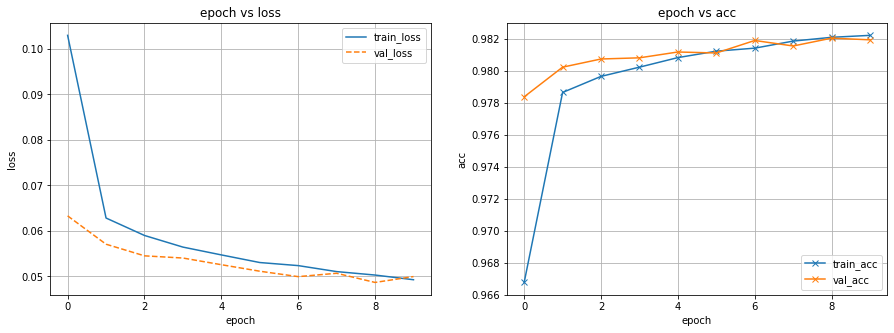

In [30]:
fig = plt.figure(figsize=(15,5))

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Plot Metric ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_train_acc, marker='x', label='train_acc')
ax2.plot(list_epoch, list_val_acc, marker='x', label='val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')


plt.show()

### Try to predict on some comments

Load the model

In [40]:
model = Model(preprocessor.num_words, EMBEDDING_DIM, embedding_matrix, 64, 10, 6)
model.load_state_dict(torch.load('./model_pytorch/model_dict_best.pt'))

<All keys matched successfully>

In [41]:
def predict_toxic(texts): 
    texts_cleaned = preprocessor.cleanse_corpus(texts)
        
    seqs = preprocessor.get_sequences_of_test_texts(texts_cleaned)
     
    # Prediction
    predicts = model(torch.tensor(seqs))
    return predicts.T

In [42]:
input_texts = ["Fuck yourself you son of a bitch", "I swear I'm gonna kill you", "I think that's fine"]

toxic, severe_toxic, obsence, threat, insult, identity_hate = predict_toxic(input_texts)

predictions = {}
predictions['Toxic score'] = toxic
predictions['Severe toxic score'] = severe_toxic
predictions['Obsence score'] = obsence
predictions['Threat score'] = threat
predictions['Insult score'] = insult
predictions['Identity hate score'] = identity_hate

for i in range(len(input_texts)):
    print('~'*100)
    print(f"\"{input_texts[i]}\":")
    for label, score in predictions.items():
        print(f"{label}: {score[i]:.4f}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"Fuck yourself you son of a bitch":
Toxic score: 0.9998
Severe toxic score: 0.6220
Obsence score: 0.9987
Threat score: 0.0373
Insult score: 0.9594
Identity hate score: 0.1080
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"I swear I'm gonna kill you":
Toxic score: 0.9275
Severe toxic score: 0.0559
Obsence score: 0.2021
Threat score: 0.8765
Insult score: 0.0506
Identity hate score: 0.0367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"I think that's fine":
Toxic score: 0.0205
Severe toxic score: 0.0001
Obsence score: 0.0040
Threat score: 0.0001
Insult score: 0.0058
Identity hate score: 0.0005


## Evaluate the model with test data

### Load and preprocess the test data

In [43]:
test_raw = pd.read_csv("./data/test.csv")
test_labels = pd.read_csv("./data/test_labels.csv")
test_raw = pd.merge(test_raw, test_labels, how='left', on='id')
test_raw = test_raw.drop(test_raw[test_raw['toxic']==-1].index)
test_raw.index = range(len(test_raw))

label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
test_targets = test_raw[label_names].values

Take a look at the test data

In [44]:
print(test_raw.head())
print(len(test_targets))
print(test_raw['comment_text'])

                 id                                       comment_text  toxic  \
0  0001ea8717f6de06  Thank you for understanding. I think very high...      0   
1  000247e83dcc1211                   :Dear god this site is horrible.      0   
2  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...      0   
3  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...      0   
4  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
63978
0        Thank you for understanding. I think very high...
1                         :Dear god this site is horrible.
2        "::: Somebody will invariably tr

Cleanse the data. 

This time we check how many tokens in the test data are covered by the train vocab before and after the cleansing.

In [45]:
print('-'*21 + '\n|Before cleansing...|\n' + '-'*21)
vocab_test = corpus_to_vocab(test_raw['comment_text'])
oov_words_text = embedding_coverage(vocab_test, preprocessor.word2idx)
print(f"oov word examples:\n{oov_words_text[:10]}")

print('-'*21 + '\n|Cleansing corpus...|\n' + '-'*21)
test = pd.DataFrame()
test['comment_text'] = preprocessor.cleanse_corpus(test_raw['comment_text'])

print('-'*20 + '\n|After cleansing...|\n' + '-'*20)
vocab_test = corpus_to_vocab(test['comment_text'])
oov_words_test = embedding_coverage(vocab_test, preprocessor.word2idx) 
print(f"oov word examples:\n{oov_words_text[:10]}")

---------------------
|Before cleansing...|
---------------------
Embeddings founded for 12.21% of vocab
Embeddings founded for 67.84% of all texts
oov word examples:
[('I', 58698), ('"', 33393), ('==', 31155), ('The', 14136), ('-', 9794), ('If', 8512), ("I'm", 6253), ('You', 6135), ('It', 5963), ('This', 5760)]
---------------------
|Cleansing corpus...|
---------------------
--------------------
|After cleansing...|
--------------------
Embeddings founded for 42.76% of vocab
Embeddings founded for 96.19% of all texts
oov word examples:
[('I', 58698), ('"', 33393), ('==', 31155), ('The', 14136), ('-', 9794), ('If', 8512), ("I'm", 6253), ('You', 6135), ('It', 5963), ('This', 5760)]


Get the sequences of test texts

In [46]:
seqs_test = preprocessor.get_sequences_of_test_texts(list(test['comment_text']))
print(len(seqs_test))

63978


### Evaluate the model by the test data

In [47]:
lossfunction = nn.BCELoss() 

model.eval() # Set the model be 'evaluate mode' 
test_loss = 0 # to sum up each batch
correct = 0

test_X = seqs_test
test_y = test_targets.tolist()

test_dataset = SDDataset(test_X, test_y)

num_test = len(test_y)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = args.batch_size, shuffle = False)
num_batches = len(test_dataloader)

with torch.no_grad():
    for batch_X, batch_y in test_dataloader:
        
        if args.gpu:
            # ****** Transfer data to GPU ****** #
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        pred_y = model(batch_X)
        
        loss = lossfunction(pred_y, batch_y)

        test_loss += loss.item()

        correct += (pred_y > 0.5).float().eq(batch_y).sum().item()

test_loss = test_loss / num_batches

test_acc = correct / (num_test * 6)

print(f'Test loss: {test_loss: .4f}') 
print(f'Test binary accuracy: {test_acc: .4f}')

Test loss:  0.0692
Test binary accuracy:  0.9729


## Remark

Let's understand the metrics. The binary accuracy used to moniter and evaluate the model performance calculates the accuracy of the predictions for all entries (toxicity categories) of all data samples. This can be illustrated by the following simply example:

In [ ]:
from keras.metrics import binary_accuracy

In [ ]:
labels = torch.tensor([[0, 1, 0, 1, 0, 0], [1, 1, 0, 0, 1, 1]], dtype = torch.float32)
results = torch.tensor([[0.1, 0.2, 0.9, 0.6, 0.6, 0.7], [0.8, 0.9, 0.1, 0.4, 0.7, 0.7]], dtype = torch.float32)

print((results > 0.5).float().eq(labels).sum() / (labels.size()[0] * labels.size()[1]))

Because we have 12 entries in total and 8 of them get predicted correctly, which leads to the result of 8/12 = 0.6666667.

Our model achieved 0.9729 on the test data, which is quite good. Other metrics may be preferred according to the purpose of the specific task. Further achitecture and hyperparameter tuning and using word embeddings with higher embedding dimension could possibly lead to better performance.